In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
lorenze_df = pd.read_csv('../data/lorenze_attractor.csv', index_col=0)

In [3]:
lorenze_df.head()

,X,Y,Z,U,t
0,0.000000,1.000000,20.000000,0.0000,0.00000
1,0.002497,0.999753,19.986685,0.0005,0.00025
2,0.004986,0.999510,19.973366,0.0010,0.00050
3,0.007469,0.999273,19.960056,0.0015,0.00075
4,0.009945,0.999041,19.946756,0.0020,0.00100


In [62]:
0.00003 * 1e5

3.0

In [8]:
lorenze_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200000 entries, 0 to 199999
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   X       200000 non-null  float64
 1   Y       200000 non-null  float64
 2   Z       200000 non-null  float64
 3   U       200000 non-null  float64
 4   t       200000 non-null  float64
dtypes: float64(5)
memory usage: 9.2 MB


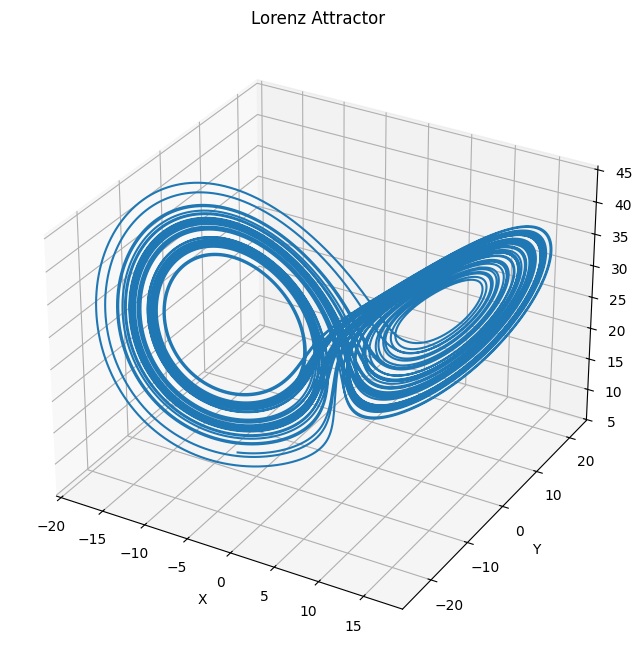

In [4]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot(lorenze_df['X'], lorenze_df['Y'], lorenze_df['Z'])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Attractor')
plt.show()

Text(0.5, 0, 'Time Steps')

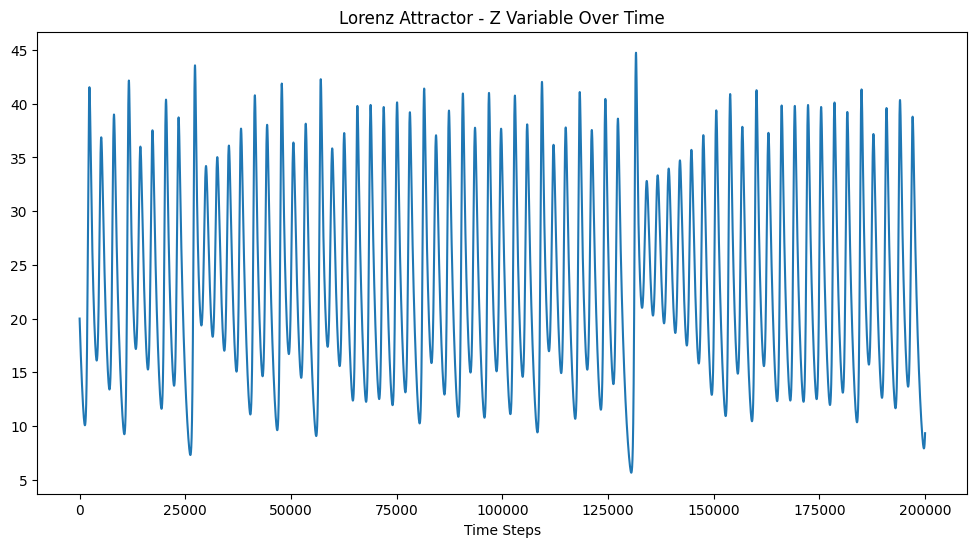

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(lorenze_df['Z'], label='Z variable')
plt.title('Lorenz Attractor - Z Variable Over Time')
plt.xlabel('Time Steps')


# Create sequences

In [5]:
def create_sequences(
        data, 
        window_size=50,
        prediction_steps=1
    ):
    X_output, X_exogenous = [], []
    y = []
    features = data[
        ["X", "Y"]
    ]
    for i in range(
        len(data) - window_size - prediction_steps + 1
    ):
        X_exogenous.append(features[i:i+window_size])
        X_output.append(data['Z'][i:i+window_size])
        y.append(data.loc[i+window_size, 'Z'])
    return np.array(X_exogenous),np.array(X_output), np.array(y)

In [6]:
X_exogenous, X_output, y = create_sequences(
    lorenze_df, 
    window_size=50,
    prediction_steps=1
)
X_exogenous.shape, X_output.shape, y.shape

((199950, 50, 2), (199950, 50), (199950,))

# Short term  flucations

CNN based models: BiTCN, TimeNet, TCN

In [12]:
from neuralforecast import NeuralForecast
from neuralforecast.models import TCN, BiTCN, TimesNet
from neuralforecast.losses.pytorch import DistributionLoss, GMM, MSE

In [13]:
model_timesnet = TimesNet(h=12,
    input_size=24,
    hidden_size = 16,
    conv_hidden_size = 32,
    loss=MSE(),
    scaler_type='standard',
    learning_rate=1e-3,
    max_steps=100,
    val_check_steps=50,
    early_stop_patience_steps=2,
    futr_exog_list=['X', 'Y','U']
)


Seed set to 1


In [14]:
for name, module in model_timesnet.named_children():
    print(f"{name}: {module}")

loss: MSE()
padder_train: ConstantPad1d(padding=(0, 12), value=0.0)
scaler: TemporalNorm()
model: ModuleList(
  (0-1): 2 x TimesBlock(
    (conv): Sequential(
      (0): Inception_Block_V1(
        (kernels): ModuleList(
          (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
          (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (3): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
          (4): Conv2d(16, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
          (5): Conv2d(16, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
        )
      )
      (1): GELU(approximate='none')
      (2): Inception_Block_V1(
        (kernels): ModuleList(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
          (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): Conv2d(32, 16, kernel_size=(5,

In [ ]:
model_bitcn = BiTCN(h=12,
    input_size=24,
    loss=GMM(n_components=7, level=[80,90]),
    max_steps=100,
    scaler_type='standard',
    futr_exog_list=['y_[lag12]'],
    hist_exog_list=None,
    stat_exog_list=['airline1'],
    windows_batch_size=2048,
    val_check_steps=10,
    early_stop_patience_steps=-1,
) 


In [ ]:
model_tcn = TCN(h=12,
    input_size=-1,
    loss=DistributionLoss(distribution='Normal', level=[80, 90]),
    learning_rate=5e-4,
    kernel_size=2,
    dilations=[1,2,4,8,16],
    encoder_hidden_size=128,
    context_size=10,
    decoder_hidden_size=128,
    decoder_layers=2,
    max_steps=500,
    scaler_type='robust',
    futr_exog_list=['y_[lag12]'],
    hist_exog_list=None,
    stat_exog_list=['airline1'],
)